### Data Ingestion (1)

- Data ingestion from ACRA, MasterDB and SSIC mapping, this data will be merged and filter with selected industry to get the specific company havent been researched by MR.

In [46]:
# Standard library
import os
import glob
import re
import time
import asyncio

# Third-party HTTP / async
import requests
import aiohttp
import nest_asyncio

# Data & analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Web scraping
import scrapy
from scrapy_playwright.page import PageMethod
from bs4 import BeautifulSoup

# Fuzzy matching
from fuzzywuzzy import fuzz, process


### Getting Master DB via Google API

In [47]:
# --- OPTIMIZED: Handle timeouts, fetch with retries, and increase timeout limits ---

from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import os
import pandas as pd
import re
import socket
import time

sheet_id = '1ipwIl7fciIlddvOUqGLpNlVQufw7Xd26Qa-YuJcx-xE'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']

SERVICE_ACCOUNT_FILE = os.getenv("GOOGLE_APPLICATION_CREDENTIALS", "credentials.json")
if not os.path.exists(SERVICE_ACCOUNT_FILE):
    raise FileNotFoundError(
        f"Service account file not found at '{SERVICE_ACCOUNT_FILE}'. "
        "Set GOOGLE_APPLICATION_CREDENTIALS to the full path, or place credentials.json next to this notebook."
    )

# --- FIX: Set timeout BEFORE building the service ---
socket.setdefaulttimeout(300)  # 5 minutes - MUST be set before build()

credentials = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
service = build('sheets', 'v4', credentials=credentials)
sheet = service.spreadsheets()

range_a1 = "'MASTER DATABASE 2025 Template'!A:ZZ"

# --- Fetch with retry logic ---
max_retries = 3
retry_count = 0
values = None

while retry_count < max_retries:
    try:
        print(f"Fetching data from Google Sheets (attempt {retry_count + 1}/{max_retries})...")
        result = sheet.values().get(
            spreadsheetId=sheet_id,
            range=range_a1
        ).execute()
        values = result.get('values', [])
        print("✅ Data fetched successfully!")
        break
    except (socket.timeout, TimeoutError) as e:
        retry_count += 1
        if retry_count < max_retries:
            wait_time = 2 * retry_count  # Exponential backoff: 2s, 4s, 6s
            print(f"⚠️ Timeout occurred: {type(e).__name__}. Retrying in {wait_time}s... ({retry_count}/{max_retries})")
            time.sleep(wait_time)
        else:
            print("❌ Failed after maximum retries. Try reducing the range or check your connection.")
            raise
    except Exception as e:
        error_str = str(e).lower()
        if any(keyword in error_str for keyword in ['timeout', 'timed out', 'connection', 'network']):
            retry_count += 1
            if retry_count < max_retries:
                wait_time = 2 * retry_count
                print(f"⚠️ Network error: {e}. Retrying in {wait_time}s... ({retry_count}/{max_retries})")
                time.sleep(wait_time)
            else:
                print("❌ Failed after maximum retries due to network issues.")
                raise
        else:
            print(f"❌ Non-retryable error: {e}")
            raise

if values:
    header = values[0]
    data_rows = values[1:]

    max_len = max([len(header)] + [len(r) for r in data_rows]) if data_rows else len(header)

    if len(header) < max_len:
        header = header + [f'col_{i+1}' for i in range(len(header), max_len)]

    normalized_rows = [row + [''] * (max_len - len(row)) for row in data_rows]

    Master_DB_df = pd.DataFrame(normalized_rows, columns=header)
    print(f"Successfully loaded {len(Master_DB_df)} rows and {len(Master_DB_df.columns)} columns")
else:
    Master_DB_df = pd.DataFrame()
    print("No data found in the sheet")

# ---------------- CLEANING FUNCTIONS ----------------

def clean_ssic_code(value):
    if pd.isna(value) or value == '':
        return None
    try:
        cleaned = re.sub(r"[^0-9]", "", str(value).strip())
        return int(cleaned) if cleaned else None
    except (ValueError, TypeError):
        return None

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    new_cols = [
        re.sub(r"_+", "_", re.sub(r"[^A-Z0-9]", "_", col.upper().strip())).strip("_")
        for col in df.columns
    ]
    df.columns = new_cols
    return df

# ---------------- PROCESS MASTER DB ----------------

columns_to_keep = [
    "Company Registration Number (UEN)",
    "ACRA REGISTERED NAME",
    "Brand/Deal Name/Business Name",
    "Primary SSIC Code",
    "PIC NAME 1 Contact Number",
    "PIC 1 email address",
    "Website URL",
    "Parent Industry Type",
    "Sub Industry"
]

existing_cols = [c for c in columns_to_keep if c in Master_DB_df.columns]
if not existing_cols:
    raise ValueError("None of the required columns found in the dataframe")

master_db_df = Master_DB_df[existing_cols].copy()
master_db_df = standardize_columns(master_db_df)

uen_cols = [c for c in master_db_df.columns if "UEN" in c]
if not uen_cols:
    raise ValueError("UEN column not found after standardization")

uen_col = uen_cols[0]

master_db_df["UEN"] = (
    master_db_df[uen_col].astype(str).str.upper().str.replace(r"[^A-Z0-9]", "", regex=True)
)
master_db_df["UEN"] = master_db_df["UEN"].replace(['', 'NAN', 'NONE'], None)
master_db_df = master_db_df.drop(columns=[uen_col])

rename_map = {
    "BRAND_DEAL_NAME_BUSINESS_NAME": "BRAND_NAME",
    "PRIMARY_SSIC_CODE": "SSIC_CODE",
}

master_db_df = master_db_df.rename(columns={k: v for k, v in rename_map.items() if k in master_db_df.columns})

for col in ["ACRA_REGISTERED_NAME", "BRAND_NAME"]:
    if col in master_db_df.columns:
        master_db_df[col] = (
            master_db_df[col].astype(str).str.strip().str.upper().replace(['', 'NAN', 'NONE'], None)
        )

if "SSIC_CODE" in master_db_df.columns:
    master_db_df["SSIC_CODE"] = master_db_df["SSIC_CODE"].apply(clean_ssic_code)

required_cols = ["UEN", "ACRA_REGISTERED_NAME", "BRAND_NAME", "SSIC_CODE"]
available_cols = [c for c in required_cols if c in master_db_df.columns]
master_db_df = master_db_df[available_cols].copy()

master_db_df = master_db_df[
    master_db_df["UEN"].notna() & (master_db_df["UEN"].astype(str).str.strip() != "")
]

print(f"Final dataset: {len(master_db_df)} rows, {len(master_db_df.columns)} columns")
master_db_df


Fetching data from Google Sheets (attempt 1/3)...
✅ Data fetched successfully!
Successfully loaded 18973 rows and 66 columns
Final dataset: 18291 rows, 4 columns


,UEN,ACRA_REGISTERED_NAME,BRAND_NAME,SSIC_CODE
0,04799400B,AIK BEE TEXTILE CO,AIK BEE TEXTILE CO,46411.0
1,03376200K,SERANGOON GARDEN CLINIC AND DISPENSARY,GARDEN CLINIC,550263.0
2,06239600E,SALON DE BENZIMEN,SALON DE BENZIMEN,96021.0
3,06952000C,SU LAN LADIES FASHION,SU LAN LADIES FASHION,14103.0
4,10381600C,SIN HAI PRINTING SERVICE,SIN HAI PRINTING SERVICE,18113.0
...,...,...,...,...
18968,202306640R,MISTER MOBILE POTONG PASIR PTE. LTD.,MISTER MOBILE (POTONG PASIR),47411.0
18969,202103010N,MISTER MOBILE JURONG PTE. LTD.,MISTER MOBILE (JURONG),47411.0
18970,201734006N,MISTER MOBILE HOUGANG PTE. LTD.,MISTER MOBILE (HOUGANG),95120.0
18971,202210879W,MISTER MOBILE CHINATOWN PTE. LTD.,MISTER MOBILE (CHINATOWN),47411.0


### Getting ACRA Data (Filter by Live, Live Company only & non relevant ssic code)
- last downloaded oct 25

In [48]:

folder_path = "Acra_Data"

# Get all CSV file paths inside the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read and combine all CSVs
# Using low_memory=False to avoid DtypeWarning for mixed types
df = pd.concat((pd.read_csv(f, low_memory=False) for f in csv_files), ignore_index=True)


df.columns = df.columns.str.upper()


acra_data = df[[
    "UEN",
    "ENTITY_NAME",
    "BUSINESS_CONSTITUTION_DESCRIPTION",
    "ENTITY_TYPE_DESCRIPTION",
    "ENTITY_STATUS_DESCRIPTION",
    "REGISTRATION_INCORPORATION_DATE",
    "PRIMARY_SSIC_CODE",
    "SECONDARY_SSIC_CODE",
    "STREET_NAME",
    "POSTAL_CODE"
]].copy()

# Convert to proper data types
acra_data['UEN'] = acra_data['UEN'].astype('string')
acra_data['ENTITY_NAME'] = acra_data['ENTITY_NAME'].astype('string')
acra_data['BUSINESS_CONSTITUTION_DESCRIPTION'] = acra_data['BUSINESS_CONSTITUTION_DESCRIPTION'].astype('string')
acra_data['ENTITY_TYPE_DESCRIPTION'] = acra_data['ENTITY_TYPE_DESCRIPTION'].astype('string')
acra_data['ENTITY_STATUS_DESCRIPTION'] = acra_data['ENTITY_STATUS_DESCRIPTION'].astype('string')
acra_data['REGISTRATION_INCORPORATION_DATE'] = pd.to_datetime(acra_data['REGISTRATION_INCORPORATION_DATE'], errors='coerce')

# Clean string columns — trim, remove extra spaces, uppercase
for col in [
    'UEN',
    'ENTITY_NAME',
    'BUSINESS_CONSTITUTION_DESCRIPTION',
    'ENTITY_TYPE_DESCRIPTION',
    'ENTITY_STATUS_DESCRIPTION',
    'STREET_NAME',
    'POSTAL_CODE'
]:
    acra_data[col] = (
        acra_data[col]
        .fillna('')
        .str.strip()
        .str.replace(r'\s+', ' ', regex=True)
        .str.upper()
    )

# Replace placeholders with NaN for standardization
acra_data.replace(['NA', 'N/A', '-', ''], np.nan, inplace=True)

# Convert registration date to dd-mm-yyyy string (optional)
acra_data['REGISTRATION_INCORPORATION_DATE'] = acra_data['REGISTRATION_INCORPORATION_DATE'].dt.strftime('%d-%m-%Y')

# Filter only live entities (LIVE COMPANY or LIVE)
acra_data = acra_data[
    acra_data['ENTITY_STATUS_DESCRIPTION'].isin(['LIVE COMPANY', 'LIVE'])
].reset_index(drop=True)

# Exclude specific PRIMARY_SSIC_CODE values (supposedly the data would be 600k plus but when we exclude this would lessen)
exclude_codes = [
    46900, 47719, 47749, 47539, 47536, 56123,
    10711, 10712, 10719, 10732, 10733, 93209
]

acra_data = acra_data[~acra_data['PRIMARY_SSIC_CODE'].isin(exclude_codes)].reset_index(drop=True)

In [49]:
acra_data

,UEN,ENTITY_NAME,BUSINESS_CONSTITUTION_DESCRIPTION,ENTITY_TYPE_DESCRIPTION,ENTITY_STATUS_DESCRIPTION,REGISTRATION_INCORPORATION_DATE,PRIMARY_SSIC_CODE,SECONDARY_SSIC_CODE,STREET_NAME,POSTAL_CODE
0,00182000A,AIK SENG HENG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,07-02-1975,46302,na,FISHERY PORT ROAD,619742
1,00233500W,ASIA STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,28-10-1974,46411,20234,SIMS AVENUE,387509
2,00733000J,AIK CHE HIONG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,02-11-1974,32909,46900,ANG MO KIO INDUSTRIAL PARK 2A,568049
3,00927000X,A WALIMOHAMED BROS,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,12-11-1974,46411,66126,JELLICOE ROAD,208767
4,01173000E,ANG TECK MOH DEPARTMENT STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,30-10-1974,47711,47214,WOODLANDS STREET 12,738623
...,...,...,...,...,...,...,...,...,...,...
537323,T25LL0518K,ZEUS BARBERS LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,16-05-2025,96021,na,KELANTAN LANE,200031
537324,T25LL0858C,ZENSE SPACE LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,01-08-2025,43301,46900,YISHUN INDUSTRIAL STREET 1,768161
537325,T25LL0870A,ZIQZEQ PROCUREMENT LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,04-08-2025,70209,46100,SIN MING LANE,573969
537326,T25LL1049B,ZHONG XIN TRAVEL LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,08-09-2025,79102,79101,JALAN BAHAGIA,320034


### Getting SSIC Industry code

In [50]:
# --- CONFIG ---
file_path = "./SSIC_Code/mapped_ssic_code.xlsx"

# --- LOAD DATA ---
mapped_ssic_code = pd.read_excel(file_path)

# --- STANDARDIZE COLUMN NAMES ---  
# Uppercase, strip spaces, replace spaces with underscores
mapped_ssic_code.columns = (
    mapped_ssic_code.columns
    .str.strip()
    .str.upper()
    .str.replace(" ", "_")
)

# --- KEEP ONLY DESIRED COLUMNS ---
columns_to_keep = ["PARENT_INDUSTRY", "INDUSTRY_TYPE", "SUB_INDUSTRY", "SSIC_CODES", "DESCRIPTION"]
mapped_ssic_code = mapped_ssic_code[columns_to_keep].copy()

# --- CLEAN SSIC_CODES COLUMN ---
mapped_ssic_code["SSIC_CODES"] = (
    pd.to_numeric(mapped_ssic_code["SSIC_CODES"], errors="coerce")  # safely convert to numeric
    .fillna(0)
    .astype(int)
)

# --- CLEAN TEXT COLUMNS ---
text_cols = ["PARENT_INDUSTRY", "INDUSTRY_TYPE", "SUB_INDUSTRY", "DESCRIPTION"]
mapped_ssic_code[text_cols] = mapped_ssic_code[text_cols].apply(
    lambda col: col.astype(str).str.strip().str.title()
)

# --- REMOVE DUPLICATES & RESET INDEX ---
mapped_ssic_code = mapped_ssic_code.drop_duplicates().reset_index(drop=True)

mapped_ssic_code.head()


,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,SSIC_CODES,DESCRIPTION
0,Retail,Retail,Fashion & Apparel,47711,Retail Sale Of Clothing For Adults
1,Retail,Retail,Fashion & Apparel,47712,Retail Sale Of Children And Infants' Clothing
2,Retail,Retail,Fashion & Apparel,47715,Retail Sale Of Sewing And Clothing Accessories
3,Retail,Retail,Fashion & Apparel,47719,"Retail Sale Of Clothing, Footwear And Leather ..."
4,Retail,Retail,Fashion & Apparel,47510,Retail Sale Of Textiles


### Merge ACRA data with SSIC code

In [51]:
# Convert PRIMARY_SSIC_CODE to int
acra_data["PRIMARY_SSIC_CODE"] = (
    pd.to_numeric(acra_data["PRIMARY_SSIC_CODE"], errors="coerce")
    .fillna(0)
    .astype(int)
)

# Merge based on SSIC code
acra_data_filtered = acra_data.merge(
    mapped_ssic_code,
    how="left",
    left_on="PRIMARY_SSIC_CODE",
    right_on="SSIC_CODES"
)

# Optional: drop the duplicate 'SSIC CODES' column (keep only PRIMARY_SSIC_CODE)
acra_data_filtered = acra_data_filtered.drop(columns=["SSIC_CODES"], errors="ignore")


### FIlter Acra data with Master DB to get list of companies havent been researched  by MR

In [52]:

# Ensure both UEN columns are strings for accurate matching
acra_data_filtered['UEN'] = acra_data_filtered['UEN'].astype(str).str.strip().str.upper()
master_db_df['UEN'] = master_db_df['UEN'].astype(str).str.strip().str.upper()

# Filter out rows in acra_data_filtered whose UEN is already in master_db_df
acra_data_filtered = acra_data_filtered[~acra_data_filtered['UEN'].isin(master_db_df['UEN'])]

acra_data_filtered.shape

(524969, 14)

In [53]:
acra_data_filtered

,UEN,ENTITY_NAME,BUSINESS_CONSTITUTION_DESCRIPTION,ENTITY_TYPE_DESCRIPTION,ENTITY_STATUS_DESCRIPTION,REGISTRATION_INCORPORATION_DATE,PRIMARY_SSIC_CODE,SECONDARY_SSIC_CODE,STREET_NAME,POSTAL_CODE,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,DESCRIPTION
0,00182000A,AIK SENG HENG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,07-02-1975,46302,na,FISHERY PORT ROAD,619742,Others,Wholesale Trade,"Food, Beverages & Tobacco","Wholesale Of Livestock, Meat, Poultry, Eggs An..."
1,00233500W,ASIA STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,28-10-1974,46411,20234,SIMS AVENUE,387509,Others,Wholesale Trade,Household Goods,Wholesale Of Textiles And Leathers
2,00733000J,AIK CHE HIONG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,02-11-1974,32909,46900,ANG MO KIO INDUSTRIAL PARK 2A,568049,Others,Manufacturing,Other Specialised Manufacturing & Distribution,Other Manufacturing Industries N.E.C.
3,00927000X,A WALIMOHAMED BROS,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,12-11-1974,46411,66126,JELLICOE ROAD,208767,Others,Wholesale Trade,Household Goods,Wholesale Of Textiles And Leathers
4,01173000E,ANG TECK MOH DEPARTMENT STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,30-10-1974,47711,47214,WOODLANDS STREET 12,738623,Retail,Retail,Fashion & Apparel,Retail Sale Of Clothing For Adults
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537323,T25LL0518K,ZEUS BARBERS LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,16-05-2025,96021,na,KELANTAN LANE,200031,Services,Services,Hair Salons & Barbershops,Hairdressing Salons/Shops
537324,T25LL0858C,ZENSE SPACE LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,01-08-2025,43301,46900,YISHUN INDUSTRIAL STREET 1,768161,Others,Built Environment & Infrastructure,Construction,Renovation Contractors
537325,T25LL0870A,ZIQZEQ PROCUREMENT LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,04-08-2025,70209,46100,SIN MING LANE,573969,Others,"Finance, Legal & Real Estate","Legal, Accounting & Consultancy Activities",Management Consultancy Services N.E.C.
537326,T25LL1049B,ZHONG XIN TRAVEL LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,08-09-2025,79102,79101,JALAN BAHAGIA,320034,Others,"Tourism, Agency",Travel Agencies & Tour Operators,Travel Agencies And Tour Operators (Mainly Out...


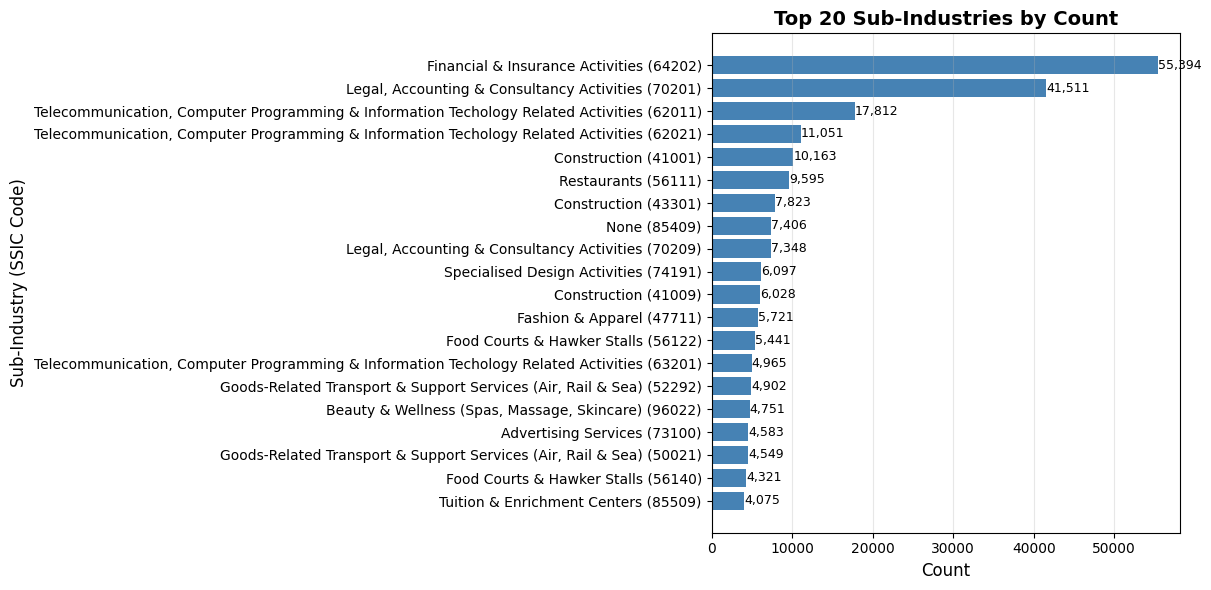


Top 20 SSIC codes with Sub-Industry names:
64202 - Financial & Insurance Activities: 55,394
70201 - Legal, Accounting & Consultancy Activities: 41,511
62011 - Telecommunication, Computer Programming & Information Techology Related Activities: 17,812
62021 - Telecommunication, Computer Programming & Information Techology Related Activities: 11,051
41001 - Construction: 10,163
56111 - Restaurants: 9,595
43301 - Construction: 7,823
85409 - None: 7,406
70209 - Legal, Accounting & Consultancy Activities: 7,348
74191 - Specialised Design Activities: 6,097
41009 - Construction: 6,028
47711 - Fashion & Apparel: 5,721
56122 - Food Courts & Hawker Stalls: 5,441
63201 - Telecommunication, Computer Programming & Information Techology Related Activities: 4,965
52292 - Goods-Related Transport & Support Services (Air, Rail & Sea): 4,902
96022 - Beauty & Wellness (Spas, Massage, Skincare): 4,751
73100 - Advertising Services: 4,583
50021 - Goods-Related Transport & Support Services (Air, Rail & Sea): 

In [54]:
# Count the values in PRIMARY_SSIC_CODE column and get top 10
ssic_counts = acra_data_filtered['PRIMARY_SSIC_CODE'].value_counts().head(20)

# Create a mapping of SSIC code to SUB_INDUSTRY name
ssic_to_subindustry = acra_data_filtered.groupby('PRIMARY_SSIC_CODE')['SUB_INDUSTRY'].first()

# Create labels with both SSIC code and SUB_INDUSTRY name
labels = [f"{ssic_to_subindustry.get(code, 'Unknown')} ({code})" for code in ssic_counts.index]

# Sort by count (ascending for horizontal bar chart)
sorted_indices = ssic_counts.sort_values(ascending=True).index
sorted_counts = ssic_counts.sort_values(ascending=True).values
sorted_labels = [f"{ssic_to_subindustry.get(code, 'Unknown')} ({code})" for code in sorted_indices]

# Create horizontal bar chart
plt.figure(figsize=(12, 6))
bars = plt.barh(sorted_labels, sorted_counts, color='steelblue')

# Add count labels on each bar
for bar, count in zip(bars, sorted_counts):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{count:,}', va='center', fontsize=9)

plt.xlabel('Count', fontsize=12)
plt.ylabel('Sub-Industry (SSIC Code)', fontsize=12)
plt.title('Top 20 Sub-Industries by Count', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nTop 20 SSIC codes with Sub-Industry names:")
for code in ssic_counts.sort_values(ascending=False).index:
    count = ssic_counts[code]
    subindustry = ssic_to_subindustry.get(code, 'Unknown')
    print(f"{code} - {subindustry}: {count:,}")

### Filter by  Industry

-   after 2020

In [62]:
# Event Organizer
# 75000 (vet), 86204 (Dental), ""

# spas
ssic_codes = [
    "96022", "96023", "96024", "96029"
]

from datetime import datetime, timedelta

# Convert to datetime FIRST (before any filtering)
acra_data_filtered["REGISTRATION_INCORPORATION_DATE"] = pd.to_datetime(
    acra_data_filtered["REGISTRATION_INCORPORATION_DATE"],
    dayfirst=True,
    errors="coerce"
)

current_date = datetime.now()
ten_years_ago = current_date - timedelta(days=10*365.25)  # Account for leap years

# Now filter by industry, status, and date all at once
acra_data_filtered_by_industry = acra_data_filtered[
    (
        (acra_data_filtered["ENTITY_STATUS_DESCRIPTION"].str.lower() == "live") |
        (acra_data_filtered["ENTITY_STATUS_DESCRIPTION"].str.lower() == "live company")
    )
    &
    (acra_data_filtered["PRIMARY_SSIC_CODE"].astype(str).isin(ssic_codes))
    # &
    # (acra_data_filtered["REGISTRATION_INCORPORATION_DATE"] > ten_years_ago)
    # &
    # (acra_data_filtered["REGISTRATION_INCORPORATION_DATE"] <= current_date)
]

# Convert date to dd/mm/yyyy format for display
acra_data_filtered_by_industry["REGISTRATION_INCORPORATION_DATE"] = (
    acra_data_filtered_by_industry["REGISTRATION_INCORPORATION_DATE"].dt.strftime("%d/%m/%Y")
)

print(acra_data_filtered_by_industry.shape)
acra_data_filtered_by_industry.head(10)

(9265, 14)


C:\Users\azlie\AppData\Local\Temp\ipykernel_95284\699708304.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acra_data_filtered_by_industry["REGISTRATION_INCORPORATION_DATE"] = (


,UEN,ENTITY_NAME,BUSINESS_CONSTITUTION_DESCRIPTION,ENTITY_TYPE_DESCRIPTION,ENTITY_STATUS_DESCRIPTION,REGISTRATION_INCORPORATION_DATE,PRIMARY_SSIC_CODE,SECONDARY_SSIC_CODE,STREET_NAME,POSTAL_CODE,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,DESCRIPTION
657,198500863C,ATOS CONSUMER PRODUCTS PTE LTD,<NA>,LOCAL COMPANY,LIVE COMPANY,15/04/1985,96024,96022,UBI CRESCENT,408570,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Massage Parlours And Foot Reflexology
1631,199600240E,ASMARA CHINA PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,11/01/1996,96022,64202,ANG MO KIO AVENUE 1,569931,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
1741,199606657K,A. D. PREFAB PTE LTD,<NA>,LOCAL COMPANY,LIVE COMPANY,13/09/1996,96024,47723,TOH YI DRIVE,590019,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Massage Parlours And Foot Reflexology
1773,199608369N,ASTERSPRING INTERNATIONAL (S) PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,23/11/1996,96029,47721,PAYA LEBAR ROAD,409051,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty And Other Personal Care Services N.E.C.
1840,199703196M,ASMARA LIFESTYLE PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,12/05/1997,96022,70201,ANG MO KIO AVENUE 1,569932,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
1985,199802336M,ADONIS INTERNATIONAL PTE LTD,<NA>,LOCAL COMPANY,LIVE COMPANY,15/05/1998,96024,96022,PEMIMPIN DRIVE,576151,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Massage Parlours And Foot Reflexology
2033,199804984N,ATOS ACADEMY PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,10/10/1998,96022,96024,UBI CRESCENT,408570,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
2074,199900448M,ATOS RESEARCH CENTRE PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,27/01/1999,96022,96024,UBI CRESCENT,408570,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
2459,200102802M,APEX COSMECEUTICAL CENTRE (YISHUN) PTE LTD,<NA>,LOCAL COMPANY,LIVE COMPANY,27/04/2001,96022,47721,YISHUN STREET 72,760748,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
2462,200102881D,APEX COSMECEUTICAL CENTRE (JURONG EAST) PTE LTD,<NA>,LOCAL COMPANY,LIVE COMPANY,02/05/2001,96022,46900,JURONG GATEWAY ROAD,600135,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas


### Get the sample data

In [56]:
acra_data_filtered_by_industry

,UEN,ENTITY_NAME,BUSINESS_CONSTITUTION_DESCRIPTION,ENTITY_TYPE_DESCRIPTION,ENTITY_STATUS_DESCRIPTION,REGISTRATION_INCORPORATION_DATE,PRIMARY_SSIC_CODE,SECONDARY_SSIC_CODE,STREET_NAME,POSTAL_CODE,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,DESCRIPTION
12518,201604503R,AOB PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,23/02/2016,96022,62011,CANTONMENT ROAD,89735,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
12523,201604572N,ABSOLUTE WELLNESS CUBE PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,24/02/2016,96022,na,FRASER STREET,189356,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
12554,201605467W,ALLTENTIC PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,03/03/2016,96024,47721,TOH GUAN ROAD,600278,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Massage Parlours And Foot Reflexology
12589,201606229R,AGELESS BEAUTY PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,10/03/2016,96022,47109,BUKIT BATOK EAST AVENUE 5,650236,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
12623,201607269D,ARCHANA BEAUTY PARADISE PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,21/03/2016,96022,47732,JALAN BESAR,208787,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537162,53508944M,ZHI ZU REFLEX THERAPY,SOLE-PROPRIETOR,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,18/08/2025,96024,na,ANG MO KIO AVENUE 1,560215,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Massage Parlours And Foot Reflexology
537170,53509480M,ZHENG SHAN MEI BEAUTY,SOLE-PROPRIETOR,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,27/08/2025,96029,na,JURONG EAST STREET 24,600253,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty And Other Personal Care Services N.E.C.
537177,53510300W,ZI JIN GE BEAUTY,SOLE-PROPRIETOR,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,11/09/2025,96022,na,UPPER PAYA LEBAR ROAD,534945,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
537184,53510639D,ZEPHYX,SOLE-PROPRIETOR,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,17/09/2025,96029,na,HOUGANG AVENUE 7,530354,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty And Other Personal Care Services N.E.C.


In [57]:
### Filter with scrapped data 

recordOwlData_1 = pd.read_parquet("./Staging/Silver/Silver_data_spa.parquet", engine="fastparquet")
recordOwlData_1

,UEN,Status,Error,Emails,Phones,Website,Facebook,LinkedIn,Instagram,TikTok,RecordOwl_Link,operational_street,operational_unit,operational_postal_code,operational_address,Phones_str
0,202344903C,success,None,None,None,https://facewashbearmalaysia.com/,None,None,None,None,https://recordowl.com/company/face-wash-bear-p...,30 EASTWOOD ROAD FAIRMOUNT CONDOMINIUM,02-12,486365,30 EASTWOOD ROAD FAIRMOUNT CONDOMINIUM 02-12 S...,None
1,53401124A,success,None,None,[+6588740083],https://landmvnb.com/,[https://www.facebook.com/landmvnb/],None,[https://www.instagram.com/landmvnb/],None,https://recordowl.com/company/lm-vietnam-nail-...,11 IRVING PLACE,01-02,369551,11 IRVING PLACE 01-02 Singapore 369551,['+6588740083']
2,53448286D,success,None,[joannggg85@gmail.com],[+6592760927],None,"[https://m.facebook.com/61551832747678/about/,...",None,None,None,https://recordowl.com/company/healthy-gold-spa,351D ANCHORVALE ROAD ANCHORVALE FIELDS,10-231,544351,351D ANCHORVALE ROAD ANCHORVALE FIELDS 10-231 ...,['+6592760927']
3,201935987C,success,None,None,[+6587883622],https://annielashacademy.com/,[https://www.facebook.com/annieleprolashartist/],None,None,None,https://recordowl.com/company/annie-beauty-aca...,8 FRENCH ROAD,13-30,200008,8 FRENCH ROAD 13-30 Singapore 200008,['+6587883622']
4,202502246E,success,None,[info@zhiholisticbeauty.com],[+6567329338],https://www.mycareersfuture.gov.sg/job/custome...,[https://www.facebook.com/zhiholisticbeautycen...,None,[https://www.instagram.com/zhiholisticbeautyce...,None,https://recordowl.com/company/zhi-holistic-bea...,17 BEDOK SOUTH ROAD,01-569,460017,17 BEDOK SOUTH ROAD 01-569 Singapore 460017,['+6567329338']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,53436219B,success,None,None,[+6582988318],None,None,None,None,None,https://recordowl.com/company/evolve-beauty-sl...,93 KOVAN ROAD VIBES @ KOVAN,01-03,548178,93 KOVAN ROAD VIBES @ KOVAN 01-03 Singapore 54...,['+6582988318']
3996,53441888X,success,None,None,[+6593894336],None,None,None,None,None,https://recordowl.com/company/lee-foot-reflexo...,1 PARK ROAD PEOPLE'S PARK COMPLEX,02-41,059108,1 PARK ROAD PEOPLE'S PARK COMPLEX 02-41 Singap...,['+6593894336']
3997,202516110K,success,None,None,None,https://aqua-beautylounge.com/,None,None,[https://www.instagram.com/aquabeautyloungemed...,None,https://recordowl.com/company/aquadream-beauty...,102 TOWNER ROAD,01-260,322102,102 TOWNER ROAD 01-260 Singapore 322102,None
3998,53503824X,success,None,None,None,https://www.mycareersfuture.gov.sg/job/persona...,None,None,None,None,https://recordowl.com/company/keepbeauty2025,236 YISHUN RING ROAD YISHUN HEARTS,01-1022,760236,236 YISHUN RING ROAD YISHUN HEARTS 01-1022 Sin...,None


In [58]:
acra_data_filtered_by_industry = acra_data_filtered_by_industry[~acra_data_filtered_by_industry['UEN'].isin(recordOwlData_1['UEN'])]
acra_data_filtered_by_industry

,UEN,ENTITY_NAME,BUSINESS_CONSTITUTION_DESCRIPTION,ENTITY_TYPE_DESCRIPTION,ENTITY_STATUS_DESCRIPTION,REGISTRATION_INCORPORATION_DATE,PRIMARY_SSIC_CODE,SECONDARY_SSIC_CODE,STREET_NAME,POSTAL_CODE,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,DESCRIPTION
12523,201604572N,ABSOLUTE WELLNESS CUBE PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,24/02/2016,96022,na,FRASER STREET,189356,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
12554,201605467W,ALLTENTIC PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,03/03/2016,96024,47721,TOH GUAN ROAD,600278,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Massage Parlours And Foot Reflexology
12731,201609803C,ARESA NAILS PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,13/04/2016,96023,47109,JOO CHIAT ROAD,427580,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Manicure And Pedicure Services
12739,201609935R,AI BEAUTY WELLNESS (PPC) PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,14/04/2016,96022,96024,AH HOOD ROAD,329984,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
12766,201611087W,A'VIC BEAUTY PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,26/04/2016,96022,96023,PARK ROAD,59108,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536968,53486429E,ZHIKANG WELLNESS,SOLE-PROPRIETOR,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,03/06/2024,96024,na,HOUGANG AVENUE 8,530684,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Massage Parlours And Foot Reflexology
536990,53489928E,ZAVA NAILS,SOLE-PROPRIETOR,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,09/08/2024,96023,na,SENGKANG WEST AVENUE,792439,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Manicure And Pedicure Services
537000,53491046K,ZUN YUE FOOT MASSAGE,SOLE-PROPRIETOR,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,02/09/2024,96024,na,ANG MO KIO AVENUE 10,560453,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Massage Parlours And Foot Reflexology
537123,53505914X,ZHONG AI TANG BEAUTY,SOLE-PROPRIETOR,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,22/06/2025,96022,na,UPPER BOON KENG ROAD,380018,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas


In [59]:
# get sample data 
acra_data_filtered_by_industry = acra_data_filtered_by_industry.sample(n=2768).reset_index(drop=True)

print(acra_data_filtered_by_industry.shape)
acra_data_filtered_by_industry.tail(10)


(2768, 14)


,UEN,ENTITY_NAME,BUSINESS_CONSTITUTION_DESCRIPTION,ENTITY_TYPE_DESCRIPTION,ENTITY_STATUS_DESCRIPTION,REGISTRATION_INCORPORATION_DATE,PRIMARY_SSIC_CODE,SECONDARY_SSIC_CODE,STREET_NAME,POSTAL_CODE,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,DESCRIPTION
2758,53508611C,POOKS,SOLE-PROPRIETOR,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,11/08/2025,96029,na,PASIR RIS DRIVE 10,510709,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty And Other Personal Care Services N.E.C.
2759,202406448W,ASTRIDW PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,19/02/2024,96022,na,PAYA LEBAR ROAD,409051,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
2760,201603391D,PT-SONG PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,10/02/2016,96024,86202,PURVIS STREET,188594,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Massage Parlours And Foot Reflexology
2761,202123636H,SIDHU'S BROW & BEAUTY CARE PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,07/07/2021,96022,49233,BISHAN STREET 11,570503,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
2762,202505598D,ELEGANT BEAUTY A PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,10/02/2025,96022,56112,BOON LAY DRIVE,649929,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
2763,202223337Z,KALLOS BEAUTY PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,05/07/2022,96022,na,ANG MO KIO STREET 62,569139,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
2764,201604454R,EVOLUTION HAIR & BEAUTY PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,23/02/2016,96022,47721,UPPER BUKIT TIMAH ROAD,588182,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
2765,202321966E,BEAUTY STROKES EYEBROW & LASHES PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,05/06/2023,96022,46900,TANNERY LANE,347805,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas
2766,202524406M,NGCOMPANY PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,04/06/2025,96023,na,TAMPINES STREET 61,524606,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Manicure And Pedicure Services
2767,202228345M,COMMON STUDIO INTERNATIONAL PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,12/08/2022,96022,na,STRATHMORE AVENUE,144053,Services,Services,"Beauty & Wellness (Spas, Massage, Skincare)",Beauty Salons And Spas


In [60]:
print(acra_data_filtered_by_industry.shape)
print(acra_data_filtered_by_industry["UEN"].is_unique)


(2768, 14)
True


In [61]:
acra_data_filtered_by_industry.to_parquet("./Staging/Bronze/bronze_data_1.parquet", index=False, engine="fastparquet")